In [73]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')

In [4]:
# salmon_data = pd.read_csv(r"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv")
# salmon_data.head()
# salmon_copy = salmon_data # Create a copy for us to work with 
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
    print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [5]:
    king_all_copy, king_data= load_data('/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv')
    print(king_all_copy)

            date  king
0     1938-05-01   201
1     1938-05-02   227
2     1938-05-03    78
3     1938-05-04    37
4     1938-05-05    29
...          ...   ...
24729 2021-04-28  2433
24730 2021-04-29  4782
24731 2021-04-30  4641
24732 2021-05-01  2087
24733 2021-05-02  2517

[24734 rows x 2 columns]
            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [83]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    
    # Todo: Normalize data with MinMaxScalar

    x_train = []
    y_train = []
    
    # Todo: Experiment with input size of input (ex. 30 days)
    
    for i in range(180,22544): # 30
        x_train.append(king_training["king"][i-180:i])
        y_train.append(king_training["king"][i])
    x_test = []
    y_test = []
    for i in range(180, 1824):
        x_test.append(king_test["king"][i-180:i])
        y_test.append(king_test["king"][i])
        
    return x_train, y_train, x_test, y_test, king_test

In [84]:
x_train, y_train, x_test, y_test, king_test = create_train_test(king_all_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)


In [60]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [78]:
def create_single_layer_rnn_model(x_train, y_train, x_test):
    '''
    create single layer rnn model trained on x_train and y_train
    and make predictions on the x_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(x_train, y_train, epochs=50, batch_size=64)

    print("predicting")
    # Finalizing predictions
    test_preds = model.predict(x_test)
    

    return model, test_preds

In [62]:
def create_GRU_model(x_train, y_train, x_test, y_test):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(x_train,y_train,epochs=1500,batch_size=150)
    

    GRU_predicted_salmon_count = regressorGRU.predict(x_test)

    return regressorGRU, GRU_predicted_salmon_count

<AxesSubplot:xlabel='date', ylabel='king'>

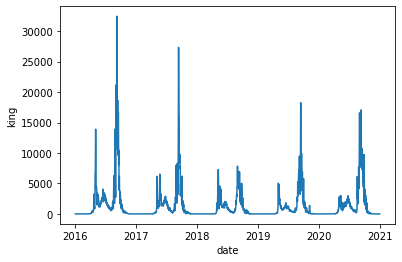

In [63]:
sns.lineplot(
    data=king_test,
    x="date", y="king"
)

In [64]:
# model, test_preds = create_single_layer_rnn_model(x_train, y_train, x_test)

In [65]:
regressorGRU, GRU_predicted_num = create_GRU_model(x_train, y_train, x_test, y_test)

Epoch 1/1500
151/151 [==============================] - 15s 54ms/step - loss: 12003730.7171
Epoch 2/1500
151/151 [==============================] - 9s 63ms/step - loss: 11914023.0576
Epoch 3/1500
151/151 [==============================] - 9s 60ms/step - loss: 10811669.3553
Epoch 4/1500
151/151 [==============================] - 9s 60ms/step - loss: 11190496.5362
Epoch 5/1500
151/151 [==============================] - 9s 59ms/step - loss: 11551954.0724
Epoch 6/1500
151/151 [==============================] - 9s 58ms/step - loss: 10813682.3553
Epoch 7/1500
151/151 [==============================] - 9s 59ms/step - loss: 11156105.3618
Epoch 8/1500
151/151 [==============================] - 9s 58ms/step - loss: 11923661.5395
Epoch 9/1500
151/151 [==============================] - 9s 63ms/step - loss: 11728844.1053
Epoch 10/1500
151/151 [==============================] - 10s 63ms/step - loss: 10821696.9622
Epoch 11/1500
151/151 [==============================] - 9s 62ms/step - loss: 11010502.

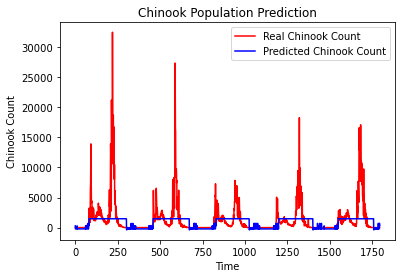

In [66]:
plot_predictions(y_test, GRU_predicted_num)

In [67]:
accuracy = accuracy_score(y_test, np.round(GRU_predicted_n3um.reshape(GRU_predicted_num.shape[0])))

In [68]:
accuracy

0.0

In [69]:
GRU_predicted_num

array([[ 291.9973 ],
       [-208.60962],
       [-208.60962],
       ...,
       [ 291.9973 ],
       [ 706.38074],
       [ 291.9973 ]], dtype=float32)

In [85]:
# test basic single layer RNN
model, test_preds = create_single_layer_rnn_model(x_train, y_train, x_test)

Epoch 1/50
350/350 [==============================] - 9s 23ms/step - loss: 12291428.4444
Epoch 2/50
350/350 [==============================] - 7s 21ms/step - loss: 13103787.7977
Epoch 3/50
350/350 [==============================] - 7s 20ms/step - loss: 12504399.1937
Epoch 4/50
350/350 [==============================] - 7s 21ms/step - loss: 13325516.2564
Epoch 5/50
350/350 [==============================] - 7s 21ms/step - loss: 13381925.4644
Epoch 6/50
350/350 [==============================] - 8s 22ms/step - loss: 12619773.6809
Epoch 7/50
350/350 [==============================] - 8s 22ms/step - loss: 14552806.9060
Epoch 8/50
350/350 [==============================] - 8s 23ms/step - loss: 12133265.5071
Epoch 9/50
350/350 [==============================] - 8s 22ms/step - loss: 13562457.2593
Epoch 10/50
350/350 [==============================] - 9s 24ms/step - loss: 12792958.5926
Epoch 11/50
350/350 [==============================] - 9s 25ms/step - loss: 13586544.7664
Epoch 12/50
350/350

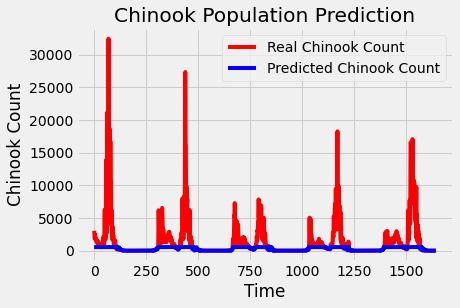

In [86]:
plot_predictions(y_test, test_preds)

In [87]:
accuracy = accuracy_score(y_test, np.round(test_preds.reshape(test_preds.shape[0])))

In [88]:
accuracy

0.03345498783454988